# Importar librerias 

In [25]:
from fastapi import FastAPI
import pandas as pd
import ast

# Carga de datos

In [26]:
df_games = pd.read_parquet('../data_clean_EDA/steam_games.parquet')
df_reviews = pd.read_parquet('../data_clean_EDA/user_reviews.parquet')
df_items = pd.read_parquet('../data_clean_EDA/australian_users_items.parquet')


In [7]:
df_games.head(1)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0,761140.0,Kotoshiro


# DEF Developer

*def developer( desarrollador : str ): Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora.

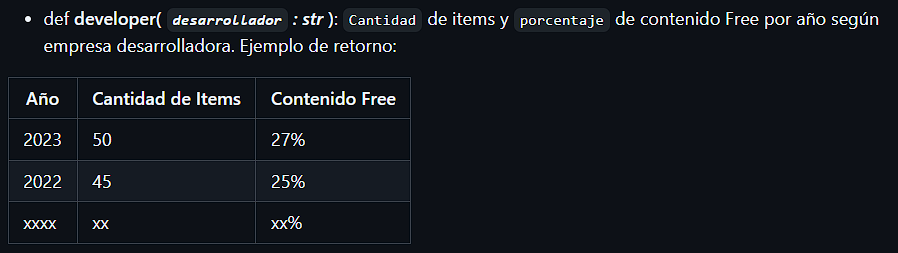

In [28]:
def developer(desarrollador: str, games_df):

    # convertimos 'release_date' a tipo fecha y filtramos por dev
    games_df['release_date'] = pd.to_datetime(games_df['release_date'], errors='coerce')
    df_dev = games_df[games_df['developer'] == desarrollador]

    # agrupamos por fecha y elemntos y dividimos por contenido gratuito
    items_por_año = df_dev.groupby(df_dev['release_date'].dt.year).size().reset_index(name='Items')
    free_por_año = df_dev[df_dev['price'] == 0].groupby(df_dev['release_date'].dt.year).size().reset_index(name='gratuito')

    # Combinamos los resultaso en uno solo 
    result_df = items_por_año.merge(free_por_año, on='release_date', how='left')
    result_df['gratuito'] = ((result_df['gratuito'].fillna(0) / result_df['Items']) * 100).round(2).astype(str) + '%'

    # Renombrar la columna de release_date para cumplir con el objetivo del ejemplo dato
    result_df.rename(columns={'release_date': 'Año'}, inplace=True)

    return result_df
# Llamada a la función
dev = input(" developer? ")
funcion1 = developer(dev, df_games)
print(funcion1)

    Año  Items gratuito
0  2018      1     0.0%


------------------------------------------------------------------------------------------------------------------------------------------------------------------

# DEF UserData

Debe devolver cantidad de dinero gastado por el usuario, el porcentaje de recomendación en base a reviews.recommend y cantidad de items. <br>

Ejemplo de retorno: <br>
 * {"Usuario X" : us213ndjss09sdf, "Dinero gastado": 200 USD, "% de recomendación": 20%, "cantidad de items": 5}

In [27]:
def userdata(User_id, df_items, df_games, df_reviews):

    # Filtrmos por usuario y calculamos el dinero gastado 
    user_items = df_items[df_items['user_id'] == User_id]
    dinero_gastado = user_items.merge(df_games[['id', 'price']], left_on='item_id', right_on='id')['price'].sum()
    items_count = user_items['items_count'].sum()

    # Filtrarmos por usuario 
    user_reviews = df_reviews[df_reviews['user_id'] == User_id]
    # Calculamos el porcentaje de recomendación 
    if user_reviews.shape[0] > 0:
        recommendation_percentage = (user_reviews['recommend'].sum() / user_reviews.shape[0]) * 100
    else:
        recommendation_percentage = 0 

    resultado = {
        "Usuario": str(User_id),
        "Dinero gastado": f"{dinero_gastado:.2f} USD",
        "% de recomendación": f"{recommendation_percentage:.2f}%",  
        "Cantidad de items": items_count
    }
    
    result_df = pd.DataFrame(list(resultado.items()), columns=['Descripción', 'Valor'])


    return result_df

usuario = input("Id_usuario: ")
funcion2 = userdata(usuario, df_items, df_games, df_reviews)
print(funcion2)


          Descripción            Valor
0             Usuario  us213ndjss09sdf
1      Dinero gastado         0.00 USD
2  % de recomendación            0.00%
3   Cantidad de items                0


------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
df_reviews.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,sentiment_analysis
0,Wackky,http://steamcommunity.com/id/Wackky,0,"Posted October 21, 2012.","Last edited November 25, 2013.",550,1 of 1 people (100%) found this review helpful,1,2
1,kevinator23,http://steamcommunity.com/id/kevinator23,0,"Posted July 6, 2015.",Last edited March 8.,218620,2 of 5 people (40%) found this review helpful,1,2
2,Lord_Exploit,http://steamcommunity.com/id/Lord_Exploit,0,"Posted March 13, 2015.","Last edited March 19, 2015.",311560,6 of 10 people (60%) found this review helpful,1,2
3,76561198141443390,http://steamcommunity.com/profiles/76561198141...,0,"Posted May 3, 2015.","Last edited November 8, 2015.",730,3 of 4 people (75%) found this review helpful,1,2
4,2768820078,http://steamcommunity.com/id/2768820078,0,Posted April 18.,Last edited April 23.,310950,2 of 3 people (67%) found this review helpful,1,1


# DEF UserForGenre 

 Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año de lanzamiento.
 
 * Ejemplo de retorno: {"Usuario con más horas jugadas para Género X" : us213ndjss09sdf, "Horas jugadas":[{Año: 2013, Horas: 203}, {Año: 2012, Horas: 100}, {Año: 2011, Horas: 23}]}


In [24]:
def UserForGenre(genero: str, df_games, df_items):
    # Convertir el campo 'release_date' a un formato legible y extraer el año
    df_games['release_year'] = pd.to_datetime(df_games['release_date'], unit='ms').dt.year
    
    # Filtrar por género asegurando que no sea None
    genero_play = df_games[df_games['genres'].apply(lambda x: x is not None and genero in x)]

    # Verificar si el DataFrame filtrado está vacío
    if genero_play.empty:
        return {"Mensaje": f"No hay datos para el género '{genero}'"}

    # Unir con df_items usando la columna id y item_id
    usuario = genero_play.merge(df_items, left_on='id', right_on='item_id')

    # Calcular las horas jugadas por usuario
    usuario_h = usuario.groupby('user_id')['playtime_forever'].sum().reset_index()

    # Verificar si hay datos después del merge
    if usuario_h.empty:
        return {"Mensaje": f"No hay datos para el género '{genero}'"}

    # Encontrar el usuario con más horas jugadas
    usuario_max_horas = usuario_h.loc[usuario_h['playtime_forever'].idxmax()]['user_id']

    # Calcular la acumulación de horas jugadas por año de lanzamiento
    horas_por_año = usuario.groupby('release_year')['playtime_forever'].sum().reset_index()
    horas_por_año.rename(columns={'playtime_forever': 'Horas'}, inplace=True)

    # Convertir a la estructura requerida
    horas_jugadas = horas_por_año.to_dict(orient='records')

    # Retornar el diccionario en el formato solicitado
    result = {
        f"Usuario con más horas jugadas para Género {genero}": usuario_max_horas,
        "Horas jugadas": horas_jugadas
    }

    return result

gen = input(" Genero? ")
funcion3 = UserForGenre(gen, df_games, df_items)
print(funcion3)


ValueError: You are trying to merge on object and float64 columns for key 'id'. If you wish to proceed you should use pd.concat

------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
df_reviews_copy = df_reviews
df_items_copy = df_items
df_games_copy = df_games

# DEF best_developer_year

 def best_developer_year( año : int ): Devuelve el top 3 de desarrolladores con juegos MÁS recomendados por usuarios para el año dado. (reviews.recommend = True y comentarios positivos)

In [18]:
def best_developer_year(año: int):
    # Filtrar juegos lanzados en el año dado en df_games
    juegos_del_año = df_games[df_games['release_year'] == año]
    
    # Convertir 'item_id' en df_reviews y 'id' en df_games a string para hacer el merge correctamente
    df_reviews['item_id'] = df_reviews['item_id'].astype(str)
    juegos_del_año['id'] = juegos_del_año['id'].astype(str)
    
    # Unir df_reviews con df_games usando item_id y id para obtener los juegos y sus desarrolladores
    reviews_con_juegos = df_reviews.merge(juegos_del_año, left_on='item_id', right_on='id')
    
    # Filtrar solo reseñas recomendadas y con el máximo sentimiento positivo
    df_filtrado = reviews_con_juegos[(reviews_con_juegos['recommend'] == 1) & 
                                     (reviews_con_juegos['sentiment_analysis'] == reviews_con_juegos['sentiment_analysis'].max())]
    
    # Agrupar por desarrollador y contar las recomendaciones
    top_developers = df_filtrado.groupby('developer')['recommend'].sum()
    
    # Ordenar los desarrolladores por número de recomendaciones en orden descendente
    top_developers = top_developers.sort_values(ascending=False)
    
    # Tomar los top 3 desarrolladores
    top_3_developers = top_developers.head(3)
    
    # Crear el diccionario ordenado con los top 3 desarrolladores
    top_developers_dict = {}
    for i, (developer, recomendaciones) in enumerate(top_3_developers.items(), 1):
        puesto = f"Puesto {i}"
        top_developers_dict[puesto] = developer

    return top_developers_dict


------------------------------------------------------------------------------------------------------------------------------------------------------------------

# DEF Developer_reviews_analysis

Según el desarrollador, se devuelve un diccionario con el nombre del desarrollador como llave y una lista con la cantidad total de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento como valor positivo o negativo.

* Ejemplo de retorno: {'Valve' : [Negative = 182, Positive = 278]}


In [22]:
def developer_reviews_analysis(desarrollador, df_reviews, df_games):
   

    df_reviews_copy['item_id'] = df_reviews_copy['item_id'].astype(str)
    df_games_copy['id'] = df_games_copy['id'].astype(str)
    merged_data = pd.merge(df_reviews_copy, df_games_copy, left_on='item_id', right_on='id', how='left')
    filtered_data = merged_data[merged_data['sentiment_analysis'] != 1]
    grouped_data = filtered_data.groupby(['developer', 'sentiment_analysis']).size().unstack(fill_value=0)
    if desarrollador in grouped_data.index:
        # Extraer los conteos de reseñas negativas (0) y positivas (2)
        developer_reviews = grouped_data.loc[desarrollador]

        # Crear el formato de salida como lista de diccionarios
        developer_reviews_list = [
            {"Negativas": developer_reviews.get(0, 0)},  # Cantidad de reseñas negativas
            {"Positivas": developer_reviews.get(2, 0)}   # Cantidad de reseñas positivas
        ]

        return {desarrollador: developer_reviews_list}
    else:
        return f"No se encontró información de: {desarrollador}"

# Ejemplo de uso:
desarrollador = input('developer: ')
resultado = developer_reviews_analysis(desarrollador, df_reviews, df_games)
print(resultado)


No se encontró información sobre la desarrolladora Poolians.com
